In [31]:
import numpy as np
import torch
import scipy as scp
from functools import reduce
from itertools import product, permutations
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Operator, state_fidelity, DensityMatrix
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

np.set_printoptions(edgeitems=300, threshold=20000, linewidth=150)
torch.set_printoptions(edgeitems=300, threshold=20000, linewidth=150)


def N_cz_gates(graph, N):
    """
    Construct ring of CZ gates for N > 1 qubits.
    """
    cz = torch.tensor([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, -1]], dtype=torch.float64)
    val = []
    if N < 2:
        print("Error")
    elif N == 2:
        return cz
    else:
        for i in range(len(graph)-1):
            cz_i = cz
            for j in range(N):
                if np.all(graph[i] > j):
                    cz_i = torch.kron(torch.eye(2), cz_i)
                elif np.all(graph[i] < j):
                    cz_i = torch.kron(cz_i, torch.eye(2))
                
            val.append(cz_i)

        val.append(torch.kron(torch.tensor([[1, 0], [0, 0]]), torch.eye(2**(N-1))) + torch.kron(torch.kron(torch.tensor([[0, 0], [0, 1]]), torch.eye(2**(N-2))), torch.tensor([[1, 0], [0, -1]])))
        val[-1] = val[-1].to(torch.float64)

        return reduce(torch.matmul, val)


def QFT1(N): # Don't use, still needs to be fixed.
    """
    Construct the Quantum Fourier Transform for N qubits.
    """
    def phase(phi):
        return np.array([[1, 0], [0, np.exp(complex(1, 0)*phi)]])
        
    p = [np.array([[0, 1], [1, 0]]), np.array([[0, complex(0, -1)], [complex(0, 1), 0]]), np.array([[1, 0], [0, -1]])]
    proj = [np.array([[1, 0], [0, 0]]), np.array([[0, 0], [0, 1]])]
    had = (p[0]+p[2])/np.sqrt(2)
    if N < 1:
        print("Error")
    elif N == 1:
        return had
    else:
        d_had = np.array([np.kron(np.eye(2**(i)), np.kron(had, np.eye(2**(N-i-1)))) for i in range(N)])
        
        val_list = [np.matmul(reduce(np.matmul, np.flip(np.array([np.kron(np.eye(2**j), np.kron(proj[0], np.kron(np.eye(2**i), np.kron(np.eye(2**1), np.eye(2**(N-i-2-j))))))
                    + np.kron(np.eye(2**j), np.kron(proj[1], np.kron(np.eye(2**i), np.kron(phase(np.pi*2**(-1-i)), np.eye(2**(N-i-2-j)))))) for i in range(N-j-1)]))), d_had[j]) for j in range(N-1)]+ [d_had[-1]]
        val_list = np.flip(np.array(val_list))
            
        return torch.tensor(reduce(np.matmul, val_list), dtype=torch.complex128)


def fidelity(den, den1):
    """
    Calculates the fidelity between state den and den1.
    """
    p = den
    q = den1

    sqrt_den_p = scp.linalg.sqrtm(p)
    fid_eig = scp.linalg.eigvals(np.einsum('ij,jk,kl -> il', sqrt_den_p, q, sqrt_den_p))

    fidelity = np.real((fid_eig[fid_eig > 0]**0.5).sum())**2
    
    return fidelity


def custom_loss(x, y):
    """
    Loss function implementing the scaled Frobenius norm squared.
    """
    df = x-y
    ld_re = torch.real(df)
    ld_im = torch.imag(df)

    return (ld_re**2+ld_im**2).sum()/ld_re.size()[0]


class ParameterizedOperator(torch.nn.Module):
    """
    The relativistic variational quantum circuit model.
    """
    def __init__(self, num_params, coupling, dt, smear, seed, Pauli_dir, dist, p, id):
        super(ParameterizedOperator, self).__init__()
        self.rng = np.random.default_rng(seed)
        self.num_UDW = num_params[0]
        self.coupling = torch.tensor(coupling)
        self.dt = torch.tensor(dt)
        self.smear = torch.tensor(smear)
        self.Pauli_dir = Pauli_dir
        self.dx = [self.coupling**2*self.dt*torch.norm(dist.unsqueeze(1)-dist.unsqueeze(0), dim=-1) for a in range(len(num_params))]
        self.tpi = torch.tensor(np.pi)
        
        # Trainable rotation angles
        self.params = [torch.tensor(np.pi*self.rng.uniform(0, 10, size=num_params[i]), requires_grad=True) for i in range(len(num_params))] # make sure this adheres to lambda^2 << params
        # Trainable angles for normal vector in rotation operators
        self.nrot1 = [torch.tensor(2*np.pi*self.rng.uniform(0, 1, size=num_params[i]), requires_grad=True) for i in range(len(num_params))]
        self.nrot2 = [torch.tensor(2*np.pi*self.rng.uniform(0, 1, size=num_params[i]), requires_grad=True) for i in range(len(num_params))]
        
        self.sym_prop = [-self.dt/(2*torch.sqrt(self.tpi)*torch.sqrt(1+self.smear**2/self.dt**2)*self.dx[i])
                         *torch.exp(-self.dx[i]**2/(4*(self.dt**2+self.smear**2)))*torch.erf(self.dx[i]/(2*self.smear*torch.sqrt(1+self.smear**2/self.dt**2))) for i in range(len(num_params))]
        self.wightman = [self.dt/(4*torch.sqrt(self.tpi)*torch.sqrt(1+self.smear**2/self.dt**2)*self.dx[i])
                         *torch.exp(-self.dx[i]**2/(4*(self.dt**2+self.smear**2)))*torch.tensor(scp.special.erfi((self.dx[i]/(2*torch.sqrt(self.dt**2+self.smear**2)).numpy()))) for i in range(len(num_params))]

        self.EntOp_list = torch.linalg.matrix_exp(torch.stack([-1j*(self.coupling**2/2)*self.Hamiltonian_NL(D-1-i, p, id) for i in range(D)]))
    
    def forward(self, den, D, calc_type, p, id):
        """
        Application of the RVQC channel for D layers to the input state den.
        """
        RotOp_list = torch.linalg.matrix_exp(torch.stack([-1j*sum([self.params[D-1-i][j]*self.NPauliOperators(D-1-i, 0, [j], p, id) for j in range(len(self.params[D-1-i]))]) for i in range(D)]))
        U = reduce(torch.matmul, torch.bmm(self.EntOp_list, RotOp_list))

        if calc_type == "Unitary":
            return U
        elif calc_type == "Channel":
            U_dag = U.adjoint()
            den_f = torch.matmul(torch.matmul(U, den), U_dag)
            den_f = self.EPhiChannel(den_f)
            return den_f

    
    def Hamiltonian_NL(self, d, p, id):
        """
        Interaction Hamiltonian for field-mediated entangling operator.
        """
        return sum([sum([self.sym_prop[d][i, j]*self.NPauliOperators(d, 1, [i, j], p, id) for j in range(i+1, len(self.dx[d]))]) for i in range(len(self.dx[d]))])


    def Hamiltonian_L(self, d, p, id):
        """
        Free Hamiltonian for local rotation operators.
        """
        return sum([self.params[d][i]*self.NPauliOperators(d, 0, [i], p, id) for i in range(len(self.params[d]))])

    
    def NPauliOperators(self, d, d1, n, p, id):
        """
        Construct Pauli operators for N qubits.
        """
        if d1 == 0:
            nrot_tot = [torch.sin(self.nrot1[d])*torch.cos(self.nrot2[d]), torch.sin(self.nrot1[d])*torch.sin(self.nrot2[d]), torch.cos(self.nrot1[d])]
            rot_mat = torch.stack([sum([nrot_tot[j][i]*p[j] for j in range(3)]) for i in range(len(n))])
            val = torch.kron(torch.kron(id[n[0]], rot_mat), id[self.num_UDW-n[0]-1])
            #val = [torch.kron(fval[i], torch.eye(2**(self.num_UDW-n[i]-1))) for i in range(len(n))]
        elif d1 == 1:
            p = p[self.Pauli_dir[d]]
            val = [torch.kron(id[n[i]], torch.kron(p, id[self.num_UDW-n[i]-1])) for i in range(len(n))]
            
        else:
            print("Error: d1 must be 0 or 1")

        return reduce(torch.matmul, val).to(torch.complex128)


    def RotOperators(self, ind):
        """
        1-qubit rotation operators.
        """
        U_R = torch.linalg.matrix_exp(-1j*self.Hamiltonian_L(ind))

        return U_R
        

    def EntOperators(self, ind):
        """
        Unitary field-mediated entangling operator.
        """
        U_C = torch.linalg.matrix_exp(-1j*(self.coupling**2/2)*self.Hamiltonian_NL(ind))

        return U_C

    
    def EPhiChannel(self, den):
        """
        Local detector-field interaction channel.
        """
        # Generate all combinations of values of mu_j and mu_j'
        mu_combinations = list(product([-1, 1], repeat=N))

        # Initialize the final operator sigma_f as a zero matrix
        sig_f = torch.zeros((2**N, 2**N), dtype=torch.complex128)

        for mu_prime in mu_combinations:
            for mu in mu_combinations:
                # Convert mu and mu' into tensors
                mu_prime_tensor = torch.tensor(mu_prime, dtype=torch.float32)
                mu_tensor = torch.tensor(mu, dtype=torch.float32)
                
                # Calculate the exponent terms
                exp_factor = torch.exp(-1j*(self.coupling**2)*torch.einsum('ij,i,j -> ', torch.imag(self.wightman), mu_prime_tensor, mu_tensor) 
                                       -(self.coupling**2/2)*torch.einsum('ij,i,j -> ', self.wightman, mu_prime_tensor-mu_tensor, mu_prime_tensor-mu_tensor))
                
                # Get the density matrix element ⟨mu | rho_0 | mu'⟩
                mu_index = int(''.join(str((m+1)//2) for m in mu), 2)
                mu_prime_index = int(''.join(str((m+1)//2) for m in mu_prime), 2)
                rho_element = den[mu_index, mu_prime_index]
                
                # Accumulate into the sigma_f operator
                sigma_f[mu_index, mu_prime_index] += exp_factor * rho_element

        return sig_f
        

# Initialize parameters
N = 6  # Total number of qubits
D = 70 # Depth
num_params = [N for i in range(D)]  
graph = [np.array([i, i+1]) for i in range(N-1)] + [np.array([N, 0])]  # List of pairs to act as CZ gates
num_agents = 10 # Total number of random number generator seeds to use for model parameter initialization

coupling = 10**(-4) # Detector coupling strength
dt = 10**(8) # Detector coupling time
smear = 10**(-8) # Scale of detector spatial coupling 
seeds = np.random.choice(10**4, size=num_agents, replace=False)
learning_rate = 0.01

Pauli_dir = [2 for i in range(D)] # Directions for Pauli operators in entangling gate; x=0, y=1, z=2 
lat_sp = [5, 3, 1] # Lattice spacings for x,y,z directions
lat_num = [3, 2, 1] # Number of detectors along each dimension of the lattice
dx_vecs = torch.tensor([[i*lat_sp[0], j*lat_sp[1], k*lat_sp[2]] for i in range(lat_num[0]) for j in range(lat_num[1]) for k in range(lat_num[2])], dtype=torch.float64) # Detector lattice position vectors

Pauli = torch.tensor([[[0, 1], [1, 0]], 
                      [[0, -1j], [1j, 0]], 
                      [[1, 0], [0, -1]]], dtype=torch.complex128)

id_list = [torch.eye(2**(i)) for i in range(N)] # List of identity matrices for different numbers of qubits to save on computation cost

# The quantum Fourier transform
QFT = torch.tensor(Operator(QFT(N, 0, False, False, False)).data, requires_grad=False, dtype=torch.complex128)

test_state = torch.randn(2**(N), dtype=torch.complex128) # Randomly generated test state for fidelity estimation
test_state = test_state/torch.linalg.vector_norm(test_state)

QFTstate = torch.matmul(QFT, test_state)
QFTstate = torch.outer(QFTstate, torch.conj(QFTstate)).numpy()

calc_type = "Unitary" # Used in model to specify whether to return unitary or density operator in forward method
den_0 = torch.zeros((2**N, 2**N), dtype=torch.complex128)

fidelity_all = [[] for i in range(num_agents)]
loss_all = [[] for i in range(num_agents)]

# Training loop
tol = 4*10**(-3)
for num in range(num_agents):
    epoch = 0
    loss_val = torch.tensor(1)
    fid_val = 0
    print("Coupling Constant: {a0}| Coupling Time: {a1}| Coupling Width: {a2}| Lattice Spacing: {a3}| Number of Qubits: {a4}| Depth: {a5}".format(a0=coupling, a1=dt, a2=smear, a3=lat_sp, a4=N, a5=D))
    operator = ParameterizedOperator(num_params, coupling, dt, smear, seeds[num], Pauli_dir, dx_vecs, Pauli, id_list).to(device)
    optimizer = torch.optim.Adam(operator.params+operator.nrot1+operator.nrot2, lr=learning_rate)
    while torch.abs(loss_val) >= tol:
        ModelU = operator.forward(den_0, D, calc_type, Pauli, id_list)
        Modelstate = torch.matmul(ModelU, test_state).detach()
        Modelstate = torch.outer(Modelstate, torch.conj(Modelstate)).numpy()
        Fidelity = fidelity(QFTstate, Modelstate)
        
        optimizer.zero_grad()
        loss = custom_loss(ModelU, QFT).to(device)
        loss.backward()
        optimizer.step()

        fid_val = Fidelity
        loss_val = loss
        epoch += 1
        fidelity_all[num].append(Fidelity)
        loss_all[num].append(loss.clone().detach().numpy())

        if epoch == 1:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            print("Fidelity: {a0}".format(a0=Fidelity))
            
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    print(f'Epoch {epoch}, Loss: {loss.item()}')
    print(f'Fidelity: {Fidelity}')
    
"""
# This section was used for hyperparameter searching
coupval = [0.0001, 0.0005, 0.001, 0.005, 0.01]
dtval = [10**(i) for i in range(10)]
latval = [[i,i] for i in range(1,11)]+[list(x) for x in permutations([i for i in range(1, 11)],2)]

for num in range(num_agents):
    epoch = 0
    loss_val = torch.tensor(1)
    fid_val = 0
    while torch.abs(loss_val) >= tol:
    #while np.abs(fid_val) <= fid_tol:
        for i1 in coupval:
            for i2 in dtval:
                for i3 in latval:
                    dx_vecs = torch.tensor([[i*i3[0], j*i3[1], k*lat_sp[2]] for i in range(lat_num[0]) for j in range(lat_num[1]) for k in range(lat_num[2])], dtype=torch.float64) # Detector lattice position vectors
                    print("Coupling Constant: {a0}| Coupling Time: {a1}| Coupling Width: {a2}| Lattice Spacing: {a3}| Number of Qubits: {a4}| Depth: {a5}".format(a0=i1, a1=i2, a2=smear, a3=i3, a4=N, a5=D))
                    operator = ParameterizedOperator(num_params, i1, i2, smear, seeds[num], Pauli_dir, dx_vecs, Pauli, id_list).to(device)
                    optimizer = torch.optim.Adam(operator.params+operator.nrot1+operator.nrot2, lr=learning_rate)
                    while torch.abs(loss_val) >= tol:
                    #while np.abs(fid_val) <= fid_tol:
                        ModelU = operator.forward(den_0, D, calc_type, Pauli, id_list)
                        Modelstate = torch.matmul(ModelU, test_state).detach()
                        Modelstate = torch.outer(Modelstate, torch.conj(Modelstate)).numpy()
                        Fidelity = fidelity(QFTstate, Modelstate)
                        
                        optimizer.zero_grad()
                        loss = custom_loss(ModelU, QFT).to(device)
                        loss.backward()
                        optimizer.step()
                
                        fid_val = Fidelity
                        loss_val = loss
                        epoch += 1
                        fidelity_all[num].append(Fidelity)
                        loss_all[num].append(loss.clone().detach().numpy())
        
                        if epoch == 1:
                            print(f'Epoch {epoch}, Loss: {loss.item()}')
                            print("Fidelity: {a0}".format(a0=Fidelity))
    
                        if (epoch == 500) and (loss.item() >= 0.09):
                            epoch = 0
                            loss_val = torch.tensor(1)
                            fid_val = 0
                            break
                            
                        if epoch % 500 == 0:
                            print(f'Epoch {epoch}, Loss: {loss.item()}')
                            #print([operator.params[i].grad for i in range(len(operator.params))])
                        
                        if (epoch % 10000 == 0) and (loss.item() > 10**(-2)):
                            epoch = 0
                            loss_val = torch.tensor(1)
                            fid_val = 0
                            print("Fidelity: {a0}".format(a0=Fidelity))
                            break
                        
        D += 5
        num_params = [N for i in range(D)]
        Pauli_dir = [2 for i in range(D)]
        
    print(f'Epoch {epoch}, Loss: {loss.item()}')
    print(f'Fidelity: {Fidelity}')
"""

Coupling Constant: 0.0001| Coupling Time: 100000000| Coupling Width: 1e-08| Lattice Spacing: [5, 3, 1]| Number of Qubits: 6| Depth: 70


/var/folders/71/wzbvtgrn1nz4tw2765x5s90r0000gn/T/ipykernel_78354/3802881965.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  *torch.exp(-self.dx[i]**2/(4*(self.dt**2+self.smear**2)))*torch.tensor(scp.special.erfi((self.dx[i]/(2*torch.sqrt(self.dt**2+self.smear**2)).numpy()))) for i in range(len(num_params))]


Epoch 1, Loss: 1.9958528226682317
Fidelity: 0.016647447321801397
Epoch 500, Loss: 0.06021494399706268
Epoch 1000, Loss: 0.03286200501722884
Epoch 1500, Loss: 0.023673670641533542
Epoch 2000, Loss: 0.01999327273915074
Epoch 2500, Loss: 0.015447850299000424
Epoch 3000, Loss: 0.01721611057633112
Epoch 3500, Loss: 0.015341957586948288
Epoch 4000, Loss: 0.008914002863061352
Epoch 4500, Loss: 0.008598245200054602
Epoch 5000, Loss: 0.010337656449164605
Epoch 5500, Loss: 0.008270163296049026
Epoch 6000, Loss: 0.007341122572665764
Epoch 6500, Loss: 0.006511534741942264
Epoch 7000, Loss: 0.007119681620296073
Epoch 7500, Loss: 0.0062126372978401675
Epoch 8000, Loss: 0.006044150609652709
Epoch 8500, Loss: 0.009843538976433584
Epoch 9000, Loss: 0.007180596784091274
Epoch 9500, Loss: 0.007922045598236635
Epoch 10000, Loss: 0.006280470173260694
Epoch 10500, Loss: 0.005398274613365788
Epoch 11000, Loss: 0.009280940030629469
Epoch 11500, Loss: 0.005778197328768932
Epoch 12000, Loss: 0.00607356159191578

'\nfor num in range(num_agents):\n    epoch = 0\n    while torch.abs(loss_val) >= tol:\n    #while np.abs(fid_val) <= fid_tol:\n        for i1 in coupval:\n            for i2 in dtval:\n                for i3 in latval:\n                    dx_vecs = torch.tensor([[i*i3[0], j*i3[1], k*lat_sp[2]] for i in range(lat_num[0]) for j in range(lat_num[1]) for k in range(lat_num[2])], dtype=torch.float64) # Detector lattice position vectors\n                    print("coupling: {a0}| dt: {a1}| lat_sp: {a2}| depth: {a3}".format(a0=i1, a1=i2, a2=i3, a3=D))\n                    operator = ParameterizedOperator(num_params, i1, i2, smear, seeds[num], Pauli_dir, dx_vecs, Pauli, id_list).to(device)\n                    optimizer = torch.optim.Adam(operator.params+operator.nrot1+operator.nrot2, lr=learning_rate)\n                    while torch.abs(loss_val) >= tol:\n                    #while np.abs(fid_val) <= fid_tol:\n                        ModelU = operator.forward(den_0, D, calc_type, Pauli, id

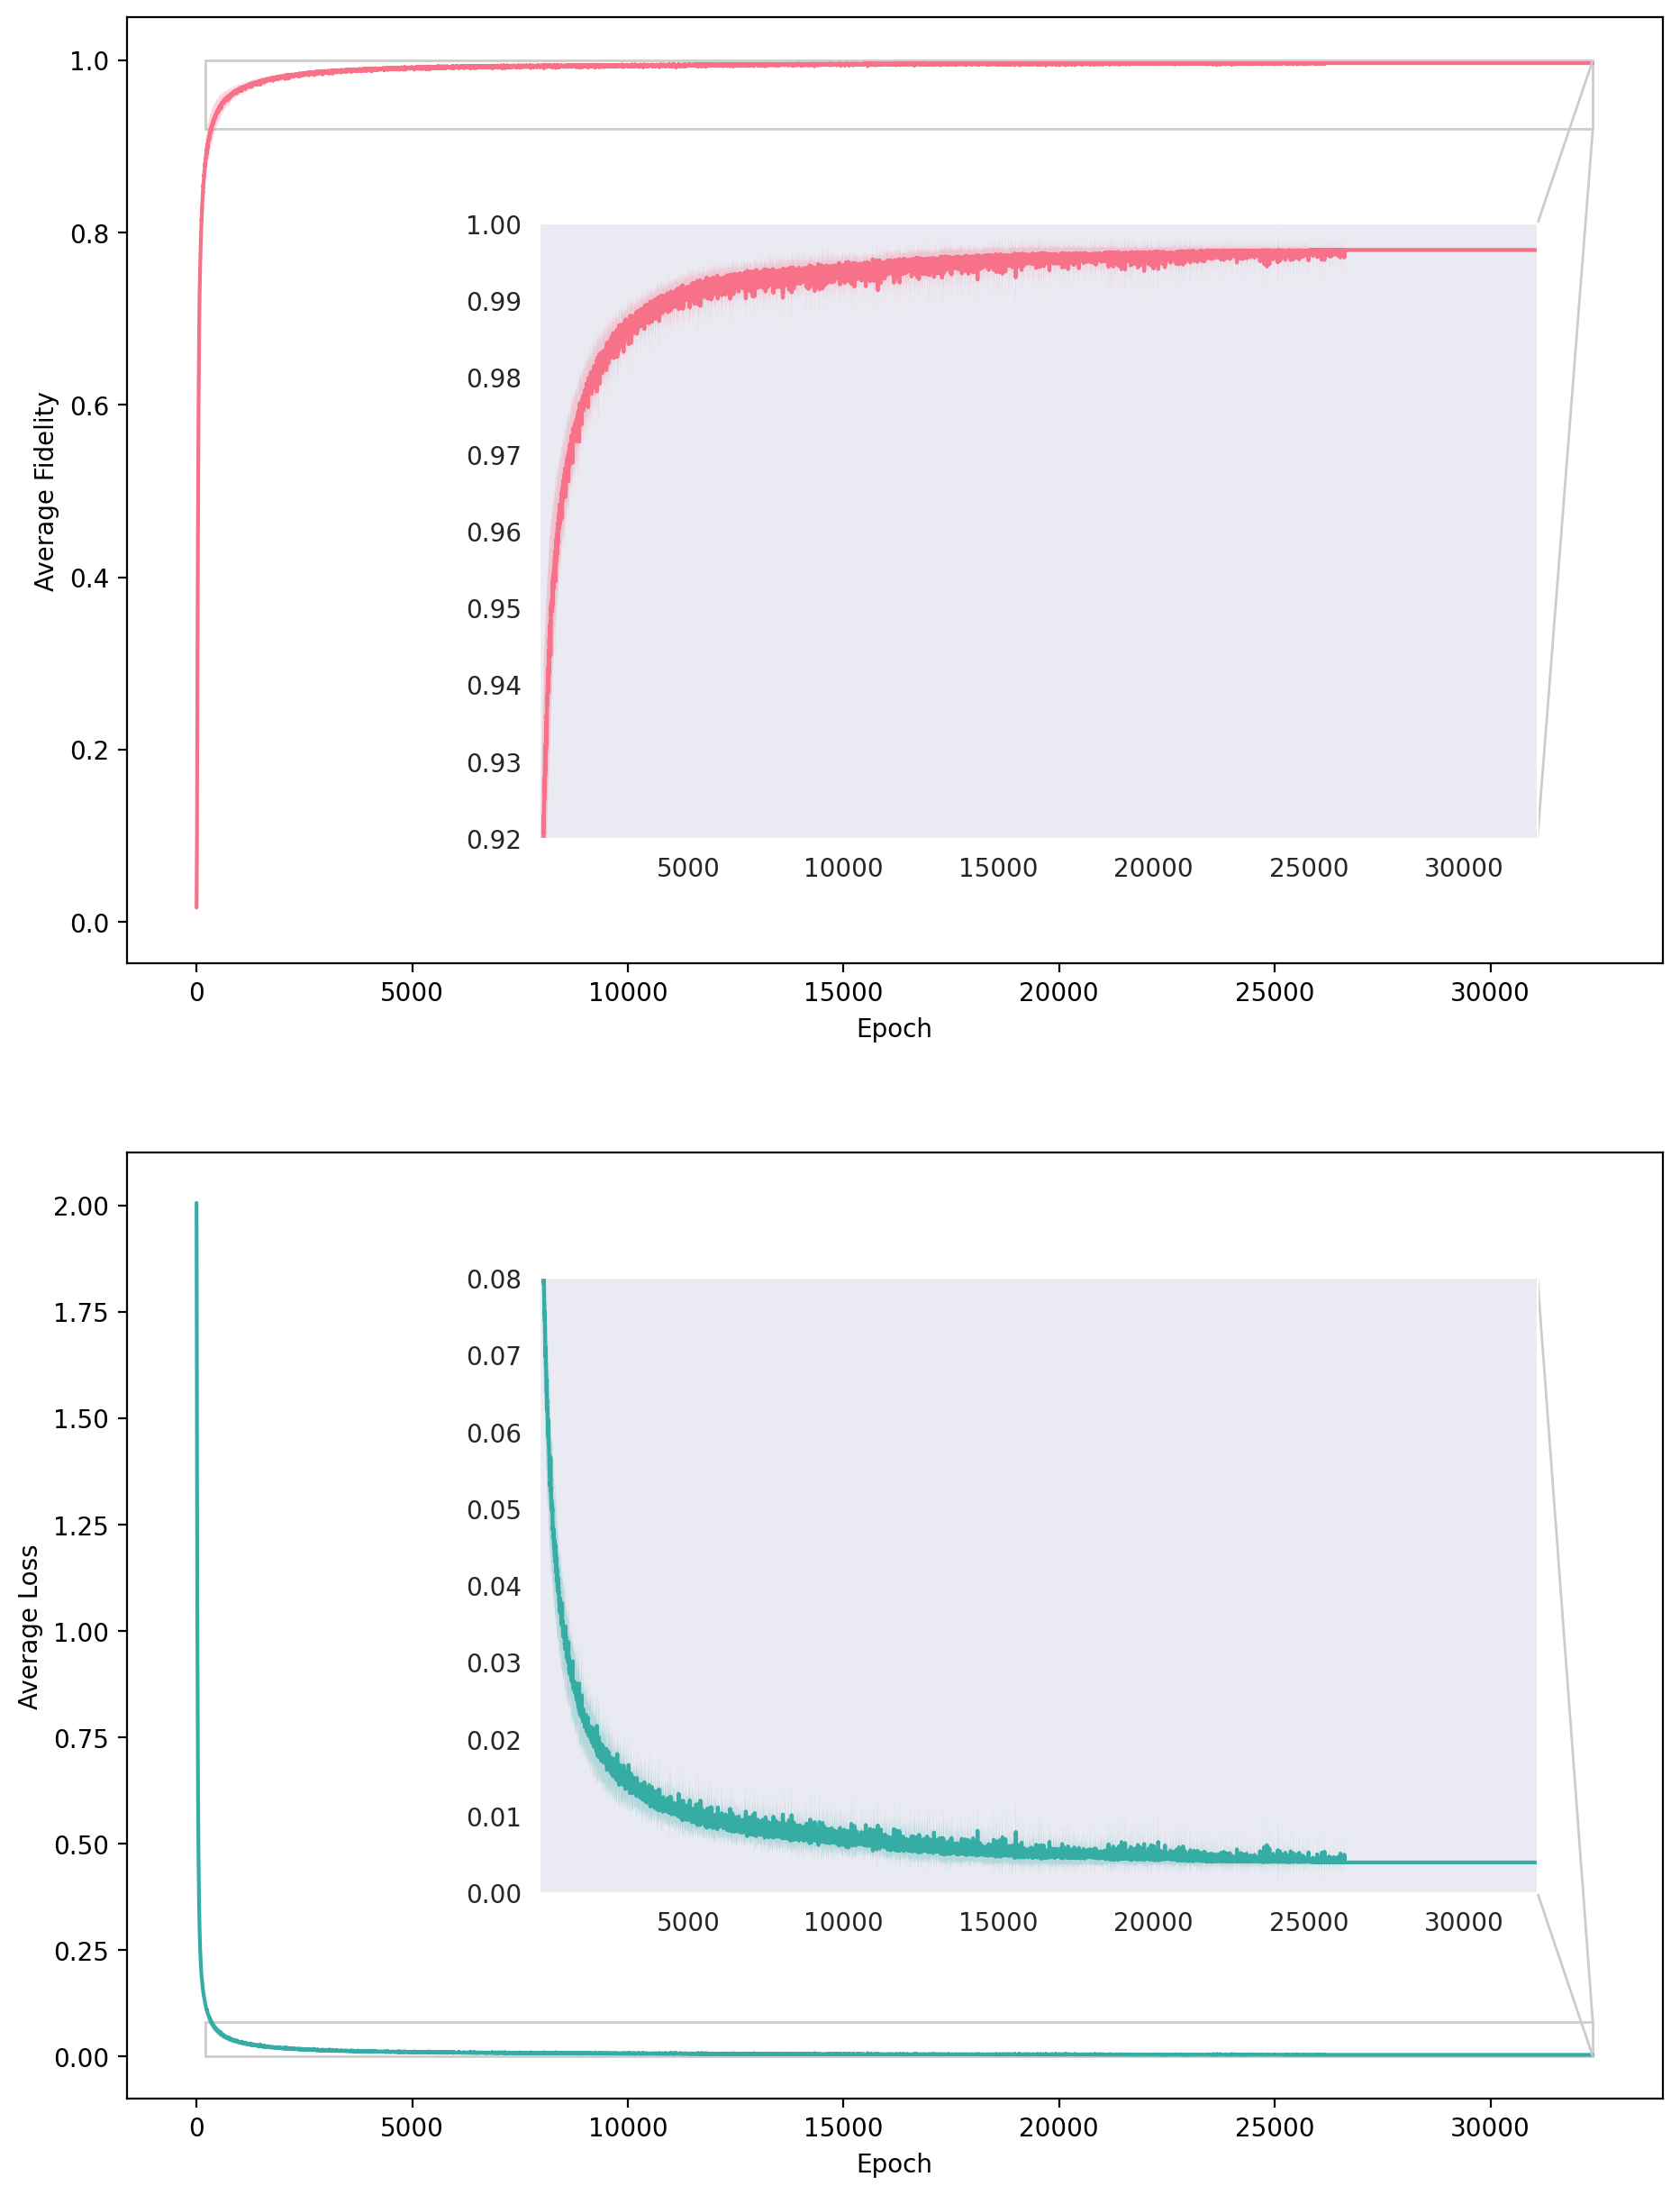

In [75]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

new_fid = []
new_loss = []
fid_len = max([len(arr) for arr in fidelity_all])    

for i in range(len(fidelity_all)):
    if len(fidelity_all[i]) != fid_len:
        temp_fid = fidelity_all[i] + [fidelity_all[i][-1] for j in range(len(fidelity_all[i]), fid_len)]
        temp_loss = loss_all[i] + [loss_all[i][-1] for j in range(len(loss_all[i]), fid_len)]
        new_fid.append(temp_fid)
        new_loss.append(temp_loss)

new_fid = np.array(new_fid)
new_loss = np.array(new_loss)

# Used for representation of fluctuations in learning curves
fid_means = np.mean(new_fid, axis=0)
fid_stds = np.std(new_fid, axis=0)
loss_means = np.mean(new_loss, axis=0)
loss_stds = np.std(new_loss, axis=0)

fig, ax = plt.subplots(2, 1, figsize=(11.0, 15.0), dpi=200)
ax[0].set_ylabel('Average Fidelity')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Average Loss')
ax[1].set_xlabel('Epoch')
colors = sns.color_palette("husl", 2)
plot_cut = len(fid_means)-0
plot_cut1 = 0
xvals = np.arange(plot_cut1, plot_cut)

with sns.axes_style("darkgrid"):
    fid_means_cut = fid_means[plot_cut1:plot_cut]
    fid_stds_cut = fid_stds[plot_cut1:plot_cut]
    loss_means_cut = loss_means[plot_cut1:plot_cut]
    loss_stds_cut = loss_stds[plot_cut1:plot_cut]
    # Define the region to magnify
    xf1, xf2, yf1, yf2 = 200, fid_len, 0.92, 1.0
    xl1, xl2, yl1, yl2 = 200, fid_len, 0.0, 0.08
    
    # Create inset for the magnified region
    ax_inset = inset_axes(ax[0], width="65%", height="65%", loc="lower right", borderpad=5)
    ax_inset.plot(xvals, fid_means_cut, c=colors[0])
    ax_inset.fill_between(xvals, y1=fid_means_cut-fid_stds_cut, y2=fid_means_cut+fid_stds_cut ,alpha=0.3, facecolor=colors[0])
    ax_inset.set_xlim(xf1, xf2)
    ax_inset.set_ylim(yf1, yf2)
    ax_inset.grid(False)
    ax_inset1 = inset_axes(ax[1], width="65%", height="65%", loc="upper right", borderpad=5)
    ax_inset1.plot(xvals, loss_means_cut, c=colors[1]) 
    ax_inset1.fill_between(xvals, y1=loss_means_cut-loss_stds_cut, y2=loss_means_cut+loss_stds_cut ,alpha=0.3, facecolor=colors[1])
    ax_inset1.set_xlim(xl1, xl2)
    ax_inset1.set_ylim(yl1, yl2)
    ax_inset1.grid(False)
    
    # Mark the inset regions on the main plots
    mark_inset(ax[0], ax_inset, loc1=1, loc2=4, fc="none", ec="0.8")
    mark_inset(ax[1], ax_inset1, loc1=1, loc2=4, fc="none", ec="0.8")
    ax[0].plot(xvals, fid_means_cut, c=colors[0]) 
    ax[0].fill_between(xvals, y1=fid_means_cut-fid_stds_cut, y2=fid_means_cut+fid_stds_cut ,alpha=0.3, facecolor=colors[0])
    ax[1].plot(xvals, loss_means_cut, c=colors[1]) 
    ax[1].fill_between(xvals, y1=loss_means_cut-loss_stds_cut, y2=loss_means_cut+loss_stds_cut ,alpha=0.3, facecolor=colors[1])
    
plt.show()

In [76]:
new_params = [list(i.clone().detach().numpy()) for i in operator.params]
new_nrot1 = [list(i.clone().detach().numpy()) for i in operator.nrot1]
new_nrot2 = [list(i.clone().detach().numpy()) for i in operator.nrot2]
print("Rotation Angles:")
print(new_params, "\n")
print("Rotation Direction Angles 1:")
print(new_nrot1, "\n")
print("Rotation Direction Angles 2:")
print(new_nrot2)

Rotation Angles:
[[10.709945762232758, 31.165614108127173, 10.75246674209506, 15.590045950482335, 28.15607451043715, 0.4541941175221143], [14.18127036531395, 10.743608088080396, 0.20299566439872765, 28.28550582039495, 9.34253092067653, 10.86111431738695], [4.660730772712137, 4.86676629701006, 17.851731101582157, 25.070767275430086, 9.571010550982598, 21.94913299012795], [18.87795448412189, 10.149471292548201, 16.791925232252602, 12.457216920217045, 15.903139769887588, 29.660514730150066], [0.5933270283692291, 28.610440321845363, 6.045025742132618, 10.362346094198926, 17.484045141832766, 1.6560419542661415], [9.426757038749349, 13.982965697965115, 3.7871056276969757, 15.046653917744166, 20.682834937898747, 20.92794524807137], [14.102907963514884, 27.179360102755776, 13.727626599488463, 6.341693377927543, 6.335170264529558, 15.752691985898856], [21.497040822886184, 12.713449756853144, 23.537395207150805, 17.495125506370446, 26.6066509235534, 2.5136282645275183], [3.2914566199955178, 15.7